<a href="https://colab.research.google.com/github/PeraHive/project-lostnfound/blob/main/RSSI%20Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Simulation Of LostnFound**

Home-seeking simulation using RSSI feedback

In [1]:
# @title
import math, random, time
from dataclasses import dataclass
from typing import Tuple, List, Dict, Optional
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from collections import deque

## **Model RSSI vs Distance**

We’ll use a simple **log-distance path loss model** with added random noise to mimic real-world signal variation:

$$
\mathrm{RSSI}(d) = P_0 - 10n \log_{10}\left(\frac{d}{d_0}\right) + X_{\sigma}
$$

Where:
- $P_0$ = reference RSSI at distance $d_0 = 1\,\mathrm{m}$  
- $n$ = path loss exponent ($\approx$ ≈ 1.465 accordint to the reference)  
- $X_{\sigma}$ = Gaussian shadowing term using measured from Table 2


**Reference**
> Wojcicki, P., Zientarski, T., Charytanowicz, M. and Lukasik, E. (2021). Estimation of the Path-Loss Exponent by Bayesian Filtering Method. Sensors, 21(6), p.1934. doi:https://doi.org/10.3390/s21061934.




### RSSI Model Functions

#### **Function: `sigma_d(distance)`**

**Purpose:**  
Interpolates the standard deviation $\sigma(d)$ of the shadowing noise for any given distance(s),  
using the "Real" dataset from Table 2 of the reference paper.

**Parameters:**  
- `distance` — Distance(s) in meters (float or NumPy array).  

**Returns:**  
- $\sigma(d)$ — Interpolated standard deviation in dB.  

**Use case:**  
Provides the distance-dependent noise spread used in the RSSI simulation.

---

#### **Function: `rssi_ideal_value(distance)`**

**Purpose:**  
Computes the *ideal (noise-free)* RSSI based on the log-distance path-loss model:

$
P_r(d) = P_0 - 10\,n\,\log_{10}\!\left(\frac{d}{d_0}\right)
$

**Parameters:**  
- `distance` — Distance(s) in meters (float or NumPy array).  

**Returns:**  
- `rssi_ideal` — Ideal RSSI (dBm).  

**Use case:**  
Generates the baseline path-loss curve without environmental fading effects.

---

#### **Function: `rssi_noisy_value(distance, rng=None)`**

**Purpose:**  
Generates a *noisy RSSI sample* by adding log-normal shadowing noise (Gaussian in dB),  
with $\sigma(d)$ varying by distance.

$
P_r(d) = P_0 - 10\,n\,\log_{10}\!\left(\frac{d}{d_0}\right) + \xi_{\sigma(d)},
\quad \xi \sim \mathcal{N}(0, 1)
$

**Parameters:**  
- `distance` — Distance(s) in meters (float or NumPy array).  
- `rng` — Optional NumPy random generator for reproducibility.  

**Returns:**  
- `rssi_noisy` — Simulated RSSI values (dBm).  

**Use case:**  
Provides realistic RSSI samples for simulations or testing algorithms  
(e.g., path-loss estimation, particle filters, or signal strength mapping).

In [2]:
# @title
# ------------------------
# Model parameters (from Wojcicki et al., Sensors 2021)
# ------------------------
P0 = -40.0      # Reference RSSI at 1 m (dBm)
n  = 1.465      # Path-loss exponent (fitted)
d0 = 1.0        # Reference distance (m)

# Real-world σ(d) data from Table 2 (Real scenario)
_dist_keys  = np.array([1, 5, 10, 15, 20, 25, 35, 50, 75, 100], dtype=float)
_sigma_real = np.array([6.0211, 6.0380, 4.4740, 4.1058, 4.8169,
                        4.2999, 5.7238, 5.9673, 5.0651, 4.2553], dtype=float)

# Interpolation function for σ(d)
def sigma_d(distance: float | np.ndarray) -> np.ndarray:
    """
    Interpolates σ(d) [dB] for any given distance(s) in meters
    using Table 2 data (Real measurements).
    """
    return np.interp(np.atleast_1d(distance), _dist_keys, _sigma_real)

# ------------------------
# Reusable core functions
# ------------------------
def rssi_ideal_value(distance: float | np.ndarray) -> np.ndarray:
    """
    Computes the ideal RSSI (no noise) using the log-distance model:
    Pr(d) = P0 - 10 * n * log10(d / d0)
    """
    distance = np.maximum(np.atleast_1d(distance), d0)
    return P0 - 10.0 * n * np.log10(distance / d0)

def rssi_noisy_value(distance: float | np.ndarray, rng=None) -> np.ndarray:
    """
    Computes a noisy RSSI sample using log-normal shadowing:
    Pr(d) = P0 - 10 * n * log10(d / d0) + ξσ(d),  ξ ~ N(0, 1)
    """
    if rng is None:
        rng = np.random.default_rng()
    ideal = rssi_ideal_value(distance)
    noise = rng.normal(0.0, sigma_d(distance))
    return ideal + noise

### Example simulation

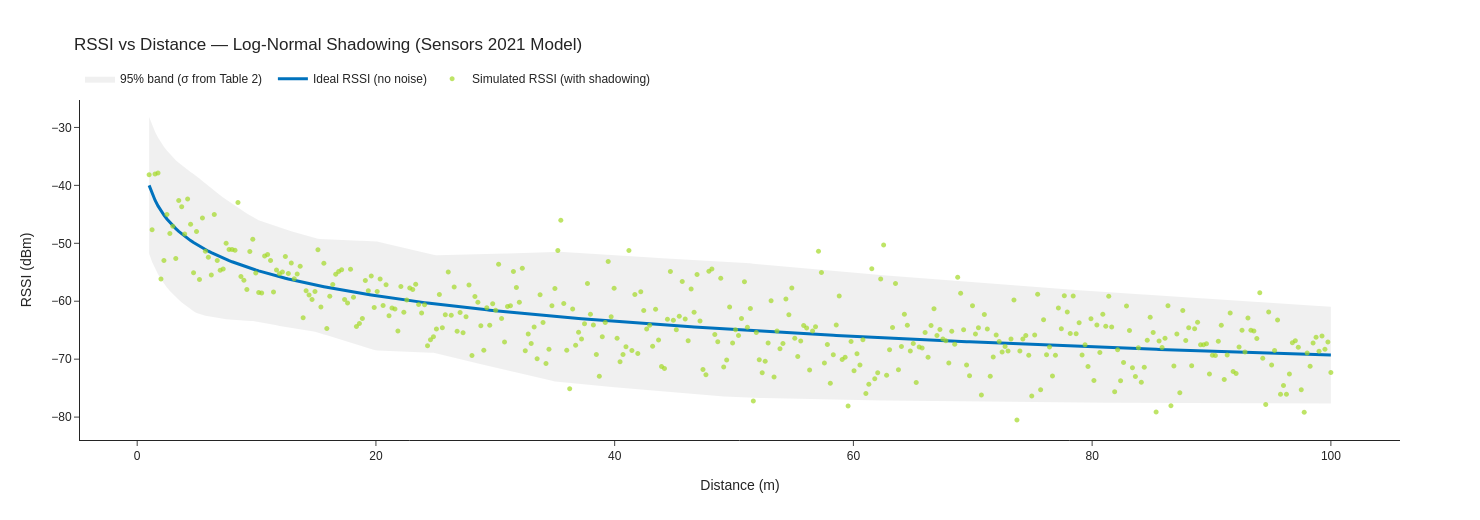

In [3]:
# @title
# Distance range similar to the paper (1–100 m)
distances = np.linspace(1.0, 100.0, 400)
rng = np.random.default_rng(42)

# Generate ideal and noisy RSSI
rssi_ideal = rssi_ideal_value(distances)
rssi_noisy = rssi_noisy_value(distances, rng)

# Confidence interval based on σ(d)
ci = 1.96 * sigma_d(distances)
upper = rssi_ideal + ci
lower = rssi_ideal - ci

# Plot
pio.templates.default = "simple_white"
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=np.concatenate([distances, distances[::-1]]),
    y=np.concatenate([upper, lower[::-1]]),
    fill="toself", fillcolor="rgba(0,0,0,0.06)", line=dict(width=0),
    name="95% band (σ from Table 2)"
))

fig.add_trace(go.Scatter(
    x=distances, y=rssi_ideal,
    mode="lines", line=dict(width=3, color='#0072BD'),
    name="Ideal RSSI (no noise)"
))

fig.add_trace(go.Scatter(
    x=distances, y=rssi_noisy,
    mode="markers", marker=dict(size=5, color='#A2D925', opacity=0.7),
    name="Simulated RSSI (with shadowing)"
))

fig.update_layout(
    title="RSSI vs Distance — Log-Normal Shadowing (Sensors 2021 Model)",
    xaxis_title="Distance (m)",
    yaxis_title="RSSI (dBm)",
    width=900, height=520,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0)
)

fig.show()


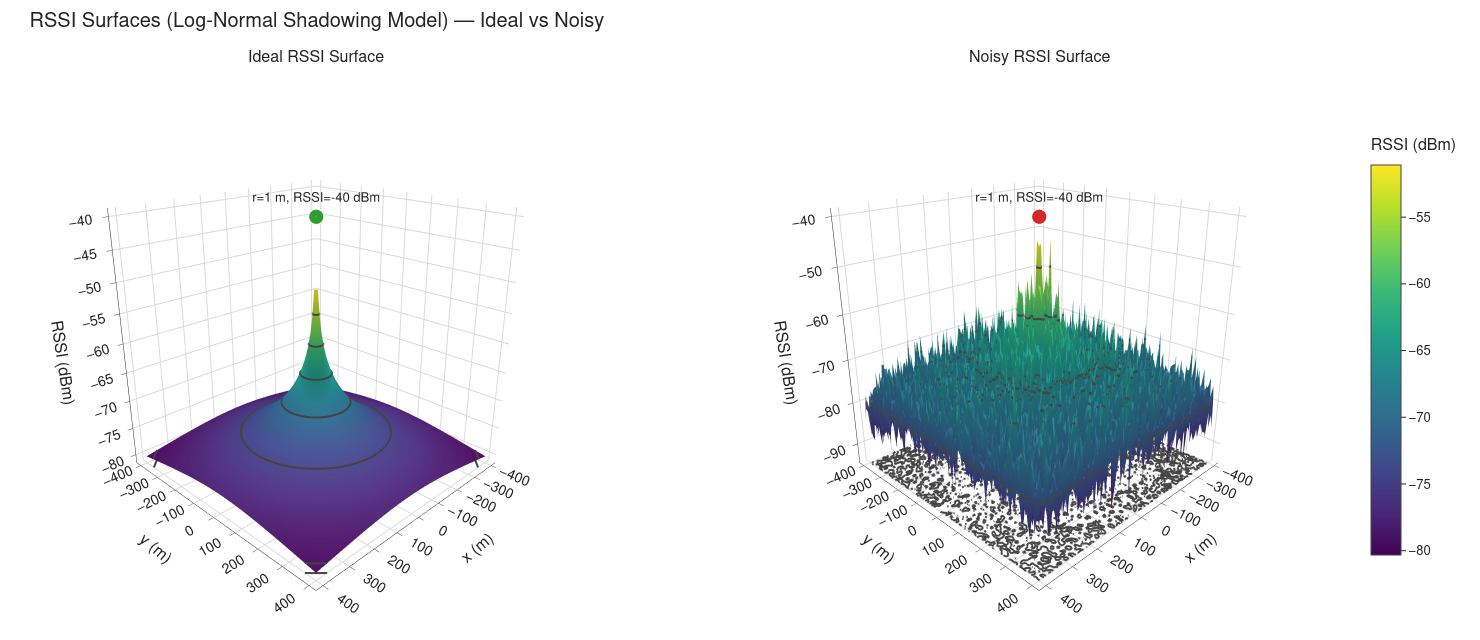

In [4]:
# @title
# Style
pio.templates.default = "simple_white"

# Grid (meters). Center (0,0) is the transmitter location.
extent = 400.0
num = 100
x = np.linspace(-extent, extent, num)
y = np.linspace(-extent, extent, num)
X, Y = np.meshgrid(x, y)

# Radial distance from the center
R = np.sqrt(X**2 + Y**2)

# Clamp distances below d0 to d0 (so the center uses the 1 m reference)
R_eff = np.maximum(R, d0)

# --- Surfaces using your functions ---
rng = np.random.default_rng(42)
Z_ideal = rssi_ideal_value(R_eff)
Z_noisy = rssi_noisy_value(R_eff, rng=rng)

# --- Figure with side-by-side subplots ---
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"type": "surface"}, {"type": "surface"}]],
    subplot_titles=("Ideal RSSI Surface", "Noisy RSSI Surface")
)

# Left: Ideal surface
fig.add_trace(
    go.Surface(
        x=X, y=Y, z=Z_ideal,
        colorscale="Viridis",
        showscale=True,
        colorbar=dict(title="RSSI (dBm)", len=0.8),
        name="Ideal RSSI surface",
        contours={"z": {"show": True, "usecolormap": False, "highlightcolor": "black", "project_z": True}}
    ),
    row=1, col=1
)

# Right: Noisy surface
fig.add_trace(
    go.Surface(
        x=X, y=Y, z=Z_noisy,
        colorscale="Viridis",
        showscale=False,  # share the left colorbar to save space
        name="Noisy RSSI surface",
        contours={"z": {"show": True, "usecolormap": False, "highlightcolor": "black", "project_z": True}}
    ),
    row=1, col=2
)

# Add a reference marker at the origin (r=d0, RSSI=P0) to BOTH scenes
ref_marker = dict(
    x=[0.0], y=[0.0], z=[P0],
    mode="markers+text",
    marker=dict(size=5, symbol="circle", line=dict(width=1, color="white")),
    text=[f"r={d0:.0f} m, RSSI={P0:.0f} dBm"],
    textposition="top center",
    hovertemplate="<b>x</b>=0 m<br><b>y</b>=0 m<br><b>RSSI</b>="+f"{P0:.1f} dBm<extra></extra>",
    showlegend=False,
)

fig.add_trace(go.Scatter3d(**ref_marker), row=1, col=1)
fig.add_trace(go.Scatter3d(**ref_marker), row=1, col=2)

# Optional: draw a faint r=d0 reference circle on BOTH scenes
theta = np.linspace(0, 2*np.pi, 400)
xc = d0 * np.cos(theta)
yc = d0 * np.sin(theta)
zc_ideal = np.full_like(theta, P0)            # For ideal surface
zc_noisy  = np.full_like(theta, P0)           # Same z label (reference line)

fig.add_trace(
    go.Scatter3d(x=xc, y=yc, z=zc_ideal, mode="lines", line=dict(width=4), name="r = 1 m circle", hoverinfo="skip", showlegend=False),
    row=1, col=1
)
fig.add_trace(
    go.Scatter3d(x=xc, y=yc, z=zc_noisy, mode="lines", line=dict(width=4), name="r = 1 m circle", hoverinfo="skip", showlegend=False),
    row=1, col=2
)

# Layout: professional look
fig.update_layout(
    title=dict(
        text="RSSI Surfaces (Log-Normal Shadowing Model) — Ideal vs Noisy",
        x=0.02, y=0.98, xanchor="left", yanchor="top",
        font=dict(size=20)
    ),
    width=1200, height=640,
    margin=dict(l=20, r=20, t=70, b=20),
    font=dict(family="Helvetica, Arial, sans-serif", size=13),
    scene=dict(
        xaxis_title="x (m)", yaxis_title="y (m)", zaxis_title="RSSI (dBm)",
        xaxis=dict(showgrid=True, gridcolor="rgba(0,0,0,0.15)"),
        yaxis=dict(showgrid=True, gridcolor="rgba(0,0,0,0.15)"),
        zaxis=dict(showgrid=True, gridcolor="rgba(0,0,0,0.15)"),
    ),
    scene2=dict(  # second scene styling
        xaxis_title="x (m)", yaxis_title="y (m)", zaxis_title="RSSI (dBm)",
        xaxis=dict(showgrid=True, gridcolor="rgba(0,0,0,0.15)"),
        yaxis=dict(showgrid=True, gridcolor="rgba(0,0,0,0.15)"),
        zaxis=dict(showgrid=True, gridcolor="rgba(0,0,0,0.15)"),
    )
)

# Camera view (applied to both scenes)
camera = dict(eye=dict(x=1.6, y=1.6, z=0.9))
fig.update_scenes(camera=camera)

fig.show()



# **Home-seeking Algorithm**

### Plot Function

In [5]:
def plot_path(result):
    path = np.array(result["path"])
    rssi = result["rssi_trace"]
    dist  = result["distance_trace"]
    stop_r = result.get("stop_radius", None)
    home = result["home"]
    subtitle = f"{result['stopped_because']} | final d={result['final_distance']:.2f} m | final RSSI={result['final_rssi']:.2f} dBm"

    fig = make_subplots(rows=1,cols=2,
        subplot_titles=[f"Path<br><sup>{subtitle}</sup>","RSSI over Steps"],
        column_widths=[0.6,0.4])
    # path
    fig.add_trace(go.Scatter(x=path[:,0],y=path[:,1],mode="lines+markers",name="Path",
                             text=[f"d={d:.2f} m" for d in dist],
                             hovertemplate="x=%{x:.2f} m<br>y=%{y:.2f} m<br>%{text}<extra></extra>",
                             line=dict(width=1),  # Reduced line width
                             marker=dict(size=4)  # Reduced marker size
                             ),1,1)
    fig.add_trace(go.Scatter(x=[home[0]],y=[home[1]],mode="markers+text",
                             text=["Home"],textposition="top center",
                             marker=dict(size=8,symbol="x"),name="Home"),1,1)  # Reduced home marker size
    if stop_r:
        t=np.linspace(0,2*np.pi,361)
        fig.add_trace(go.Scatter(x=home[0]+stop_r*np.cos(t),y=home[1]+stop_r*np.sin(t),
                                 mode="lines",line=dict(dash="dash", width=1),  # Reduced circle line width
                                 name=f"Stop {stop_r} m"),1,1)
    fig.update_xaxes(title_text="X (m)",scaleanchor="y",scaleratio=1,row=1,col=1)
    fig.update_yaxes(title_text="Y (m)",row=1,col=1)
    # rssi
    fig.add_trace(go.Scatter(x=list(range(len(rssi))),y=rssi,mode="lines+markers",name="RSSI (dBm)",
                             line=dict(width=1),  # Reduced RSSI line width
                             marker=dict(size=3)  # Reduced RSSI marker size
                             ),1,2)
    fig.update_xaxes(title_text="Step",row=1,col=2)
    fig.update_yaxes(title_text="RSSI (dBm)",row=1,col=2)
    fig.update_layout(width=1100,height=520)
    fig.show()

## **Simple Climb Algorithm**

### Mathematical Formulation of `simple_climb()` Algorithm


**Given**

- Home position: $h = (x_h, y_h) \in \mathbb{R}^2$
- Start position: $p_0 = (x_0, y_0) \in \mathbb{R}^2$
- Step distance: $\Delta s = \texttt{speed} \times \texttt{step\_size}$
- Rotation angle: $\Delta\theta = \texttt{turn\_angle}$
- Stop radius: $r_{\text{stop}}$
- Path-loss parameters: $P_0$, $n$, $d_0$


**RSSI model**

$$
RSSI_{\text{ideal}}(d) = P_0 - 10\,n\,\log_{10}\!\left(\frac{\max(d, d_0)}{d_0}\right)
$$

If noise is included:

$$
RSSI_{\text{noisy}}(d) = RSSI_{\text{ideal}}(d) + \varepsilon,
\qquad \varepsilon \sim \mathcal{N}(0, \sigma^2)
$$


**Target RSSI (stopping threshold)**

$$
RSSI_{\text{target}} = RSSI_{\text{ideal}}(\max(r_{\text{stop}}, d_0))
$$


**Initialization**

$$
\theta_0 \sim \mathcal{U}(0, 2\pi)
$$

$$
d_0 = \|p_0 - h\|_2, \quad r_0 = RSSI(d_0), \quad e_0 = |r_0|
$$


**Iterative update (for $t = 0,1,2,\dots,K-1$)**

1. **Check stopping condition**

   $$\text{If } r_t \ge RSSI_{\text{target}} \Rightarrow \text{Stop (reached home zone)}$$

2. **Move forward**

   $$
   p_{t+1} = p_t + \Delta s
   \begin{bmatrix}
   \cos\theta_t \\[4pt]
   \sin\theta_t
   \end{bmatrix}
   $$

3. **Compute new distance and RSSI**

   $$
   d_{t+1} = \|p_{t+1} - h\|_2
   $$

   $$
   r_{t+1} = RSSI(d_{t+1})
   $$

4. **Compute new error**

   $$
   e_{t+1} = |r_{t+1}|
   $$

5. **Adjust heading if not improved**

   $$
   \text{If } e_{t+1} > e_t,\
   \theta_{t+1} = (\theta_t + \Delta\theta) \bmod 2\pi;
   \quad \text{else } \theta_{t+1} = \theta_t
   $$


**Stopping conditions**

$$
r_T \ge RSSI_{\text{target}} \quad \text{(Reached target region)}
$$

or

$$
T = K \quad \text{(Maximum steps reached)}
$$

**Outputs**

- Path: $\{p_t\}_{t=0}^{T}$
- RSSI trace: $\{r_t\}_{t=0}^{T}$
- Distance trace: $\{d_t\}_{t=0}^{T}$
- Final distance $d_T$, final RSSI $r_T$
- Stop reason (target reached or max steps)


### Implementation

In [ ]:
# @title
def simple_climb(home=(0,0), start=(15,-10), step_size=0.3, speed=1.5,
                       turn_angle=math.radians(70), threshold=0.5,
                       heading=None, stop_radius=1.0, use_noisy_rssi=False,
                       rng_seed=42, max_steps= 100000):
    """
    Move forward, measure RSSI, rotate if worse.
    Stop when RSSI >= target_RSSI(stop_radius)  (if provided)
    else when |RSSI| < threshold.
    """
    rng=np.random.default_rng(rng_seed)
    def get_rssi(d):
        if use_noisy_rssi:
            rssi = to_scalar(rssi_noisy_value(d, rng))
        else:
            rssi = to_scalar(rssi_ideal_value(d))
        return float(rssi)
    def distance(p,q): return float(np.linalg.norm(p-q))
    def rssi_target_for_radius(radius_m): return float(np.atleast_1d(rssi_ideal_value(max(radius_m,d0))).item())
    def to_scalar(x) -> float: return float(np.atleast_1d(x).item())
    def move(heading):
        vx = math.cos(heading)  # East
        vy = math.sin(heading)  # North
        pos_delta = step_distance * np.array([math.cos(heading),math.sin(heading)])
        return pos_delta
    def get_initial_heading():
        heading_noise_deg=5.0
        # Ideal direction from current to home
        dx = home[0] - pos[0]
        dy = home[1] - pos[1]
        ideal_heading = math.atan2(dy, dx)

        # Add Gaussian noise in radians
        noise_rad = math.radians(rng.normal(0, heading_noise_deg))
        noisy_heading = (ideal_heading + noise_rad) % (2 * math.pi)
        return noisy_heading

    # Setup home and starting position
    home=np.array(home,float)
    pos=np.array(start,float)

    # Generate a Random Heading
    # heading=random.uniform(0,2*math.pi) if heading is None else heading
    heading=get_initial_heading()

    # Step distance
    step_distance=speed*step_size
    d = distance(pos, home)

    # Get initial RSSI
    rssi = get_rssi(d)
    err_prev = abs(rssi)

    # Start path, rssi and distance traces
    path=[tuple(pos)]
    rssi_trace=[rssi]
    distance_trace=[d]

    # Setup Target
    target=rssi_target_for_radius(stop_radius)
    print(f"Start RSSI={rssi:.2f} dBm @ d={d:.2f} m | target={target:.2f} dBm")

    for _ in range(max_steps):

        # Stop when target achieved
        if rssi>=target:
            print(f"Stop: RSSI {rssi:.2f} ≥ target {target:.2f} dBm")
            stop="Reached Target"
            break

        # move and update position
        pos_delta = move(heading)
        pos += pos_delta
        d = distance(pos, home)

        # get new RSSI
        rssi = get_rssi(d)
        err = abs(rssi)

        # turn if not improved
        if err>err_prev:
            heading=(heading+turn_angle)%(2*math.pi)

        # log data
        path.append(tuple(pos))
        rssi_trace.append(rssi)
        distance_trace.append(d)

        # update error
        err_prev=err
    else:
        stop="Max Steps Reached"

    return dict(
        path=path,
        rssi_trace=rssi_trace,
        distance_trace=distance_trace,
        final_distance=distance_trace[-1],
        final_rssi=rssi_trace[-1],
        stop_radius=stop_radius,
        stopped_because=stop,
        home=home,
    )

In [ ]:
home=(0,0)
start=(500,-500)
step_size= 2
speed=1
turn_angle=math.radians(90)
stop_radius=12

results = simple_climb(
    home=home,
    start=start,
    step_size= step_size,
    speed=speed,
    turn_angle=turn_angle,
    stop_radius=stop_radius,
    use_noisy_rssi=False,

)
plot_path(results)

results = simple_climb(
    home=home,
    start=start,
    step_size= step_size,
    speed=speed,
    turn_angle=turn_angle,
    stop_radius=stop_radius,
    use_noisy_rssi=True,

)
plot_path(results)

## **Simple Climb Algorithm + Median filter**

### Mathematical Formulation

**Median Filter**
Let $r_t$ be the raw RSSI at step $t$.
Take $W_t$ as a window of last $M$ Values.

$$\mathcal{W}_t = \{\, r_{t-i} \mid i = 0,1,\ldots,\min(M-1,t) \,\}$$

The filtered RSSI value is then the median of this window:
$$
\tilde{r}_t = \operatorname{median}(\mathcal{W}_t)
$$

If $M$ is odd, $\tilde{r}_t$ is the middle value of the sorted samples;  
if $M$ is even, it is the average of the two middle values.

In the algorithm, use $\tilde{r}_t$ instead of $r_t$ for noise-robust decisions and stopping checks.


### Implementation

In [13]:
# @title
def mf_filted_climb(home=(0,0), start=(15,-10), step_size=0.3, speed=1.5,
                       turn_angle=math.radians(70), threshold=0.5,
                       heading=None, stop_radius=1.0, use_noisy_rssi=False,
                       rng_seed=42, max_steps= 100000,mf_window=5):
    """
    Move forward, measure RSSI, rotate if worse.
    Stop when RSSI >= target_RSSI(stop_radius)  (if provided)
    else when |RSSI| < threshold.
    """
    rng=np.random.default_rng(rng_seed)
    rssi_window = deque(maxlen=mf_window)

    def get_rssi(d):
        # Compute the raw RSSI
        if use_noisy_rssi:
            rssi = to_scalar(rssi_noisy_value(d, rng))
        else:
            rssi = to_scalar(rssi_ideal_value(d))

        rssi = float(rssi)

        # --- Apply median filter ---
        rssi_window.append(rssi)
        rssi_filtered = float(np.median(rssi_window))

        return rssi_filtered

    def distance(p,q): return float(np.linalg.norm(p-q))
    def rssi_target_for_radius(radius_m): return float(np.atleast_1d(rssi_ideal_value(max(radius_m,d0))).item())
    def to_scalar(x) -> float: return float(np.atleast_1d(x).item())
    def move(heading):
        vx = math.cos(heading)  # East
        vy = math.sin(heading)  # North
        pos_delta = step_distance * np.array([math.cos(heading),math.sin(heading)])
        return pos_delta

    def get_initial_heading():
        heading_noise_deg=5.0
        # Ideal direction from current to home
        dx = home[0] - pos[0]
        dy = home[1] - pos[1]
        ideal_heading = math.atan2(dy, dx)

        # Add Gaussian noise in radians
        noise_rad = math.radians(rng.normal(0, heading_noise_deg))
        noisy_heading = (ideal_heading + noise_rad) % (2 * math.pi)
        return noisy_heading

    # Setup home and starting position
    home=np.array(home,float)
    pos=np.array(start,float)

    # Generate a Random Heading
    heading=get_initial_heading()

    # Step distance
    step_distance=speed*step_size
    d = distance(pos, home)

    # Get initial RSSI
    rssi = get_rssi(d)
    err_prev = abs(rssi)

    # Start path, rssi and distance traces
    path=[tuple(pos)]
    rssi_trace=[rssi]
    distance_trace=[d]

    # Setup Target
    target=rssi_target_for_radius(stop_radius)
    print(f"Start RSSI={rssi:.2f} dBm @ d={d:.2f} m | target={target:.2f} dBm")

    for _ in range(max_steps):

        # Stop when target achieved
        if rssi>=target:
            print(f"Stop: RSSI {rssi:.2f} ≥ target {target:.2f} dBm")
            stop="Reached Target"
            break

        # move and update position
        pos_delta = move(heading)
        pos += pos_delta
        d = distance(pos, home)

        # get new RSSI
        rssi = get_rssi(d)
        err = abs(rssi)

        # turn if not improved
        if err>err_prev:
            heading=(heading+turn_angle)%(2*math.pi)

        # log data
        path.append(tuple(pos))
        rssi_trace.append(rssi)
        distance_trace.append(d)

        # update error
        err_prev=err
    else:
        stop="Max Steps Reached"

    return dict(
        path=path,
        rssi_trace=rssi_trace,
        distance_trace=distance_trace,
        final_distance=distance_trace[-1],
        final_rssi=rssi_trace[-1],
        stop_radius=stop_radius,
        stopped_because=stop,
        home=home,
    )

In [14]:
home=(0,0)
start=(100,-100)
step_size= 2
speed=1
turn_angle=math.radians(90)
stop_radius=12
mf_window=10

results = mf_filted_climb(
    home=home,
    start=start,
    step_size= step_size,
    speed=speed,
    turn_angle=turn_angle,
    stop_radius=stop_radius,
    mf_window=mf_window,
    use_noisy_rssi=False,

)
plot_path(results)

results = mf_filted_climb(
    home=home,
    start=start,
    step_size= step_size,
    speed=speed,
    turn_angle=turn_angle,
    stop_radius=stop_radius,
    mf_window=mf_window,
    use_noisy_rssi=True,

)
plot_path(results)

Start RSSI=-71.51 dBm @ d=141.42 m | target=-55.81 dBm
Stop: RSSI -55.25 ≥ target -55.81 dBm


Start RSSI=-75.93 dBm @ d=141.42 m | target=-55.81 dBm
Stop: RSSI -55.27 ≥ target -55.81 dBm


## **Simple Climb Algorithm + EMA filter**

### Mathematical Formulation

### Exponential Moving Average (EMA) Filter

At each time step $t$, the filtered RSSI $\tilde{r}_t$ is updated recursively as:

$$
\tilde{r}_t = \alpha \, r_t + (1 - \alpha) \, \tilde{r}_{t-1}
$$

where:
- $r_t$ = current raw RSSI reading  
- $\tilde{r}_{t-1}$ = previous filtered RSSI  
- $\alpha$ = smoothing factor, $0 < \alpha \le 1$

A larger $\alpha$ gives **faster response but less smoothing**,  
while a smaller $\alpha$ gives **slower response but stronger smoothing**.

Typical values for RSSI filtering: $0.1 \le \alpha \le 0.3$

If there is no previous filtered value (first step), initialize as:
$$
\tilde{r}_0 = r_0
$$


### Implementation

In [17]:
# @title
def ema_filted_climb(home=(0,0), start=(15,-10), step_size=0.3, speed=1.5,
                       turn_angle=math.radians(70), threshold=0.5,
                       heading=None, stop_radius=1.0, use_noisy_rssi=False,
                       rng_seed=42, max_steps= 100000,ema_alpha = 0.2 ):
    """
    Move forward, measure RSSI, rotate if worse.
    Stop when RSSI >= target_RSSI(stop_radius)  (if provided)
    else when |RSSI| < threshold.
    """
    rng=np.random.default_rng(rng_seed)
    ema_alpha = 0.2        # smoothing factor (0 < alpha ≤ 1)
    ema_last = None         # store last filtered RSSI value

    def get_rssi(d):
        nonlocal ema_last
        # Compute the raw RSSI
        if use_noisy_rssi:
            rssi = to_scalar(rssi_noisy_value(d, rng))
        else:
            rssi = to_scalar(rssi_ideal_value(d))

        rssi = float(rssi)

        # --- Apply Exponential Moving Average (EMA) filter ---
        if ema_last is None:
            # initialize at first measurement
            ema_last = rssi
        else:
            ema_last = ema_alpha * rssi + (1 - ema_alpha) * ema_last

        rssi_filtered = float(ema_last)

        return rssi_filtered

    def distance(p,q): return float(np.linalg.norm(p-q))
    def rssi_target_for_radius(radius_m): return float(np.atleast_1d(rssi_ideal_value(max(radius_m,d0))).item())
    def to_scalar(x) -> float: return float(np.atleast_1d(x).item())
    def move(heading):
        vx = math.cos(heading)  # East
        vy = math.sin(heading)  # North
        pos_delta = step_distance * np.array([math.cos(heading),math.sin(heading)])
        return pos_delta

    def get_initial_heading():
        heading_noise_deg=5.0
        # Ideal direction from current to home
        dx = home[0] - pos[0]
        dy = home[1] - pos[1]
        ideal_heading = math.atan2(dy, dx)

        # Add Gaussian noise in radians
        noise_rad = math.radians(rng.normal(0, heading_noise_deg))
        noisy_heading = (ideal_heading + noise_rad) % (2 * math.pi)
        return noisy_heading

    # Setup home and starting position
    home=np.array(home,float)
    pos=np.array(start,float)

    # Generate a Random Heading
    heading=get_initial_heading()

    # Step distance
    step_distance=speed*step_size
    d = distance(pos, home)

    # Get initial RSSI
    rssi = get_rssi(d)
    err_prev = abs(rssi)

    # Start path, rssi and distance traces
    path=[tuple(pos)]
    rssi_trace=[rssi]
    distance_trace=[d]

    # Setup Target
    target=rssi_target_for_radius(stop_radius)
    print(f"Start RSSI={rssi:.2f} dBm @ d={d:.2f} m | target={target:.2f} dBm")

    for _ in range(max_steps):

        # Stop when target achieved
        if rssi>=target:
            print(f"Stop: RSSI {rssi:.2f} ≥ target {target:.2f} dBm")
            stop="Reached Target"
            break

        # move and update position
        pos_delta = move(heading)
        pos += pos_delta
        d = distance(pos, home)

        # get new RSSI
        rssi = get_rssi(d)
        err = abs(rssi)

        # turn if not improved
        if err>err_prev:
            heading=(heading+turn_angle)%(2*math.pi)

        # log data
        path.append(tuple(pos))
        rssi_trace.append(rssi)
        distance_trace.append(d)

        # update error
        err_prev=err
    else:
        stop="Max Steps Reached"

    return dict(
        path=path,
        rssi_trace=rssi_trace,
        distance_trace=distance_trace,
        final_distance=distance_trace[-1],
        final_rssi=rssi_trace[-1],
        stop_radius=stop_radius,
        stopped_because=stop,
        home=home,
    )

In [19]:
home=(0,0)
start=(100,-100)
step_size= 2
speed=1
turn_angle=math.radians(90)
stop_radius=12
ema_alpha = 0.2

results = ema_filted_climb(
    home=home,
    start=start,
    step_size= step_size,
    speed=speed,
    turn_angle=turn_angle,
    stop_radius=stop_radius,
    ema_alpha=ema_alpha,
    use_noisy_rssi=False,

)
plot_path(results)

results = ema_filted_climb(
    home=home,
    start=start,
    step_size= step_size,
    speed=speed,
    turn_angle=turn_angle,
    stop_radius=stop_radius,
    ema_alpha=ema_alpha,
    use_noisy_rssi=True,

)
plot_path(results)

Start RSSI=-71.51 dBm @ d=141.42 m | target=-55.81 dBm
Stop: RSSI -54.78 ≥ target -55.81 dBm


Start RSSI=-75.93 dBm @ d=141.42 m | target=-55.81 dBm
Stop: RSSI -55.68 ≥ target -55.81 dBm


## **Simple Climb Algorithm + MF + EMA filter**

### Implementation

In [21]:
def filted_climb(home=(0,0), start=(15,-10), step_size=0.3, speed=1.5,
                       turn_angle=math.radians(70), threshold=0.5,
                       heading=None, stop_radius=1.0, use_noisy_rssi=False,
                       rng_seed=42, max_steps= 100000,ema_alpha = 0.2, mf_window =10 ):
    """
    Move forward, measure RSSI, rotate if worse.
    Stop when RSSI >= target_RSSI(stop_radius)  (if provided)
    else when |RSSI| < threshold.
    """
    rng=np.random.default_rng(rng_seed)
    rssi_window = deque(maxlen=mf_window)
    ema_last = None         # store last filtered RSSI value

    def get_rssi(d):
        nonlocal ema_last

        for _ in range(mf_window):
          # Compute the raw RSSI
          if use_noisy_rssi:
              rssi = to_scalar(rssi_noisy_value(d, rng))
          else:
              rssi = to_scalar(rssi_ideal_value(d))

          rssi = float(rssi)

          # --- Step 1: Median filter (remove spikes) ---
          rssi_window.append(rssi)

        rssi_med = float(np.median(rssi_window))

        # --- Step 2: EMA filter (smooth residual noise) ---
        if ema_last is None:
            ema_last = rssi_med
        else:
            ema_last = ema_alpha * rssi_med + (1 - ema_alpha) * ema_last

        rssi_filtered = float(ema_last)

        return rssi_filtered

    def distance(p,q): return float(np.linalg.norm(p-q))
    def rssi_target_for_radius(radius_m): return float(np.atleast_1d(rssi_ideal_value(max(radius_m,d0))).item())
    def to_scalar(x) -> float: return float(np.atleast_1d(x).item())
    def move(heading):
        vx = math.cos(heading)  # East
        vy = math.sin(heading)  # North
        pos_delta = step_distance * np.array([math.cos(heading),math.sin(heading)])
        return pos_delta

    def get_initial_heading():
        heading_noise_deg=5.0
        # Ideal direction from current to home
        dx = home[0] - pos[0]
        dy = home[1] - pos[1]
        ideal_heading = math.atan2(dy, dx)

        # Add Gaussian noise in radians
        noise_rad = math.radians(rng.normal(0, heading_noise_deg))
        noisy_heading = (ideal_heading + noise_rad - 0.5) % (2 * math.pi)
        return noisy_heading

    # Setup home and starting position
    home=np.array(home,float)
    pos=np.array(start,float)

    # Generate a Random Heading
    heading=get_initial_heading()

    # Step distance
    step_distance=speed*step_size
    d = distance(pos, home)

    # Get initial RSSI
    rssi = get_rssi(d)
    err_prev = abs(rssi)

    # Start path, rssi and distance traces
    path=[tuple(pos)]
    rssi_trace=[rssi]
    distance_trace=[d]

    # Setup Target
    target=rssi_target_for_radius(stop_radius)
    print(f"Start RSSI={rssi:.2f} dBm @ d={d:.2f} m | target={target:.2f} dBm")

    for _ in range(max_steps):

        # Stop when target achieved
        if rssi>=target:
            print(f"Stop: RSSI {rssi:.2f} ≥ target {target:.2f} dBm")
            stop="Reached Target"
            break

        # move and update position
        pos_delta = move(heading)
        pos += pos_delta
        d = distance(pos, home)

        # get new RSSI
        rssi = get_rssi(d)
        err = abs(rssi)

        # turn if not improved
        if err>err_prev:
            heading=(heading+turn_angle)%(2*math.pi)

        # log data
        path.append(tuple(pos))
        rssi_trace.append(rssi)
        distance_trace.append(d)

        # update error
        err_prev=err
    else:
        stop="Max Steps Reached"

    return dict(
        path=path,
        rssi_trace=rssi_trace,
        distance_trace=distance_trace,
        final_distance=distance_trace[-1],
        final_rssi=rssi_trace[-1],
        stop_radius=stop_radius,
        stopped_because=stop,
        home=home,
    )

In [ ]:
home=(0,0)
start=(100,-100)
step_size= 2
speed=1
turn_angle=math.radians(90)
stop_radius=12
ema_alpha = 0.2
mf_window=10

results = filted_climb(
    home=home,
    start=start,
    step_size= step_size,
    speed=speed,
    turn_angle=turn_angle,
    stop_radius=stop_radius,
    ema_alpha=1.0,
    mf_window=1,
    use_noisy_rssi=False,

)
plot_path(results)

results = filted_climb(
    home=home,
    start=start,
    step_size= step_size,
    speed=speed,
    turn_angle=turn_angle,
    stop_radius=stop_radius,
    ema_alpha=ema_alpha,
    mf_window=mf_window,
    use_noisy_rssi=True,

)
plot_path(results)

### Testing

In [ ]:
home=(0,0)
start=(100,-100)
step_size= 10
speed=1
turn_angle=math.radians(80)
stop_radius=12
ema_alpha = 0.2
mf_window=10

for i in range(5):
    ema_alpha = (i*2)/10
    results = filted_climb(
      home=home,
      start=start,
      step_size= step_size,
      speed=speed,
      turn_angle=turn_angle,
      stop_radius=stop_radius,
      ema_alpha=ema_alpha,
      mf_window=mf_window,
      use_noisy_rssi=True,
    
    )
    
    print("ema_alpha",ema_alpha)
    print("mf_window",mf_window)
    
    plot_path(results)


Start RSSI=-79.54 dBm @ d=447.64 m | target=-54.65 dBm
Stop: RSSI -54.50 ≥ target -54.65 dBm
ema_alpha 0.2
mf_window 10


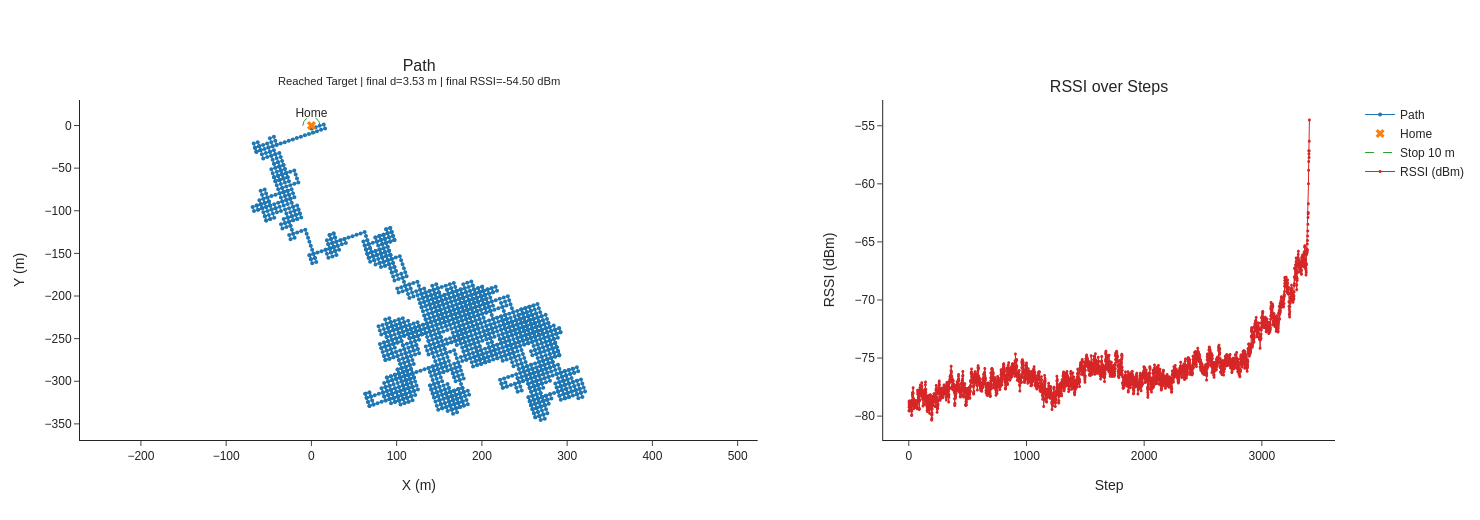

In [37]:
home=(0,0)
random_x = random.randint(100, 500)
random_y = random.randint(100, 500)
start=(random_x,- random_y)
step_size= 5
speed=10
turn_angle=math.radians(90)
stop_radius=10
ema_alpha = 0.2
mf_window=10

results = filted_climb(home=home, start=start, step_size= step_size, speed=speed, turn_angle=turn_angle, stop_radius=stop_radius, ema_alpha=ema_alpha, mf_window=mf_window, use_noisy_rssi=True)
print("ema_alpha",ema_alpha)
print("mf_window",mf_window)

plot_path(results)